<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Reinforcement learning across temporal scales

**Week 1, Day 2: Comparing Tasks**

**By Neuromatch Academy**

__Content creators:__ Leila Wehbe, Swapnil Kumar, Patrick Mineault

__Content reviewers:__ Samuele Bolotta, Lily Chamakura, RyeongKyung Yoon, Yizhou Chen, Ruiyi Zhang, Patrick Mineault

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Patrick Mineault


___


# Tutorial Objectives

*Estimated timing of tutorial: 30 minutes*

By the end of this tutorial, participants will be able to:

- Review how a reinforcement learning algorithm can be evaluated.
- Formulate a simple meta-reinforcement learning framework where an algorithm learns how to learn in different episodes.
- Investigate learning at different temporal scales.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "x4y79"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

---
# Setup



##  Install and import feedback gadget


In [1]:
# @title Install and import feedback gadget

!pip install vibecheck requests matplotlib ipython numpy scipy --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W1D2_T3"


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# @title Import dependencies

# Standard library imports
import logging
import hashlib
import os

# Third-party imports
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from IPython.display import IFrame, display, Image
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import scipy

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Button, Output

# Set up logging
logging.basicConfig(level=logging.INFO)

In [4]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fname = "trials.py" # The name of the file to be downloaded
url = "https://osf.io/swrmj/download" # URL from where the file will be downloaded
expected_md5 = "99bd315fd9a84663afbaa98f552cce79" # MD5 hash for verifying file integrity

if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

# Execute the downloaded Python file
%run trials.py

In [5]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perform high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# @title Plotting functions
# @markdown

def plot_ucb(beliefs, lb, ub, selected_arms, cumulative_reward, cum_regret, expected_rewards):
    """
    Plot the results of the multi-armed bandit task.
    """
    with plt.xkcd():
        num_trials = len(beliefs)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))
    
        ax1.plot(beliefs[:, 0], label='Left Arm')
        ax1.plot(beliefs[:, 1], label='Right Arm')
        ax1.fill_between(np.arange(num_trials), lb[:, 0], ub[:, 0], color='C0', alpha=0.1)
        ax1.fill_between(np.arange(num_trials), lb[:, 1], ub[:, 1], color='C1', alpha=0.1)
    
        ax1.plot(expected_rewards[:, 0], linestyle='--', color='C0', alpha=0.5)
        ax1.plot(expected_rewards[:, 1], linestyle='--', color='C1', alpha=0.5)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Belief')
        ax1.legend()
        ax1.set_title("Agent's Belief about Reward Probabilities")
        ax1.set_ylim(0, 1)
    
        ax2.plot(cumulative_reward)
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Cumulative Reward')
        ax2.set_title('Accumulated Reward')
    
        ax3.plot(cum_regret)
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Cumulative Regret')
        ax3.set_title('Cumulative Regret')
    
        ax4.plot(selected_arms)
        ax4.set_yticks([0, 1])
        ax4.set_xlabel('Time')
        ax4.set_title("Agent's Selection")
        ax4.set_yticklabels(['Left', 'Right'])
        plt.tight_layout()
        plt.show()

---
# Section 1: Reinforcement learning across temporal scales

In this section we will review the basics of reinforcement learning as well as we will introduce meta-reinforcement learning (meta-RL). For that, we will study how "learning to learn" is implemented in the context of a binary bandit task and how learning is affected by changing temporal scales.

In [7]:
# @title Video 1: Two-armed bandit

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '4fBU0ALeFKk'), ('Bilibili', 'BV1KM4m1m7B3')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_two_armed_bandit")

## Reinforcement learning review

Reinforcement learning is a learning paradigm where an agent interacts with an environment and learns a policy to maximize its cumulative rewards. We focus here on a simple environment: a binary "two-armed bandit" (Figure A), a name for a gambling machine found in casinos (because it steals your money). In this task, at each opportunity, the agent chooses arm $i$ (either Left $L$ or Right $R$) and gets a reward with probability $p_i$ that is unknown to the agent. On each trial, only one of the arms will return a reward, so $p_L + p_R = 1$ (which the agent does know).

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/static/two_armed_bandit.png?raw=true" width=600 />

*Figure A. Example of binary bandit. The left arm has a probability $p_L$ of giving a reward, and the right arm a probability $p_R = 1-p_L$ of giving a reward. At a given trial, the agent pulls one of the arms and receives a reward with the corresponding probability.*

The aim of the agent is to maximize its cumulative reward over a series of trials (e.g., 100 trials). This would correspond to correctly identifying the arm that returns more reward (has a higher probability) and choosing it for subsequent trials once it's sure about its choice. Thus, while solving this problem, the agent will need to balance exploration and exploitation. At a high level, more exploration is useful when the agent is not certain of which arm has more reward, and once the agent is more certain, it is more advantageous to exploit the arm that has a higher probability of reward.

Different methods are used to solve this problem. An optimal method to solve some instances of bandit problems is [Gittin indices](https://www.statslab.cam.ac.uk/~rrw1/oc/ocgittins.pdf). This method incorporates the estimated rewards and their uncertainty, and involves solving an expensive dynamical programming problem. The simplest method is [epsilon greedy](https://medium.com/@ym1942/exploring-multi-armed-bandit-problem-epsilon-greedy-epsilon-decreasing-ucb-and-thompson-02ad0ec272ee), where exploration and exploitation are balanced by choosing a random action with probability $\epsilon$ and the best known action with probability $1-\epsilon$. In the [Upper Confidence Bound (UCB)](https://medium.com/@ym1942/exploring-multi-armed-bandit-problem-epsilon-greedy-epsilon-decreasing-ucb-and-thompson-02ad0ec272ee), the choice of action also incorporates both the estimated rewards and the estimated uncertainty of the rewards. In [Thompson sampling](https://medium.com/@ym1942/exploring-multi-armed-bandit-problem-epsilon-greedy-epsilon-decreasing-ucb-and-thompson-02ad0ec272ee), the choice is made according to a Bayesian model that estimates the posterior probabilities of the reward.

### Discussion point 1
Imagine training an RL algorithm on the binary bandit problem above, with a method that depends on uncertainty about the reward probabilities (like UCB). Assume that $p_L=0.05$ and $p_R=0.95$. How rapidly will the agent become certain of its estimates of the expected reward of each arm? Do you expect the exploration phase to take a long or a short time?

What about the case when $p_L=0.51$ and $p_R=0.49$? How rapidly will the agent become certain of its estimates, and how will that affect the exploration phase?

In [ ]:
# to_remove explanation
"""
When one of the arms has a high reward, it is easier to identify it. The uncertainty of
the agent thus reduces quickly, and they spend less time in exploration. When the
probabilities of rewards are more equal (close to 0.5), many trials are needed to
reduce the uncertainty, and the exploration phase lasts a long time.
"""

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_1")

### Evaluating decision-making strategies

One key metric for evaluating an agent's strategies is cumulative regret. Regret at a specific time step refers to the difference in reward between the chosen strategy and the reward that could have been obtained by selecting the best possible action. The cumulative regret refers to the sum of the regret from the start of the episode until the current time step $T$. For our example of binary bandit, it corresponds to:

$$R(T) = \sum_{t = 1}^T (p^* - \mathbb{E}(p_{a_t})),$$

where $p^*$ is the probability of the reward for the best arm, i.e., max($p_L$, $p_r$). $\mathbb{E}(p_{a_t})$ corresponds to the expected probability of reward for the action that was chosen at the previous time $t$.

### Discussion point 2

Consider the setting where $p_L=0.25$ and $p_R=0.75$. Let's derive best and worst-case cumulative regret over 100 trials of one episode.

- Plot the lower bound of the cumulative regret, i.e. the cumulative regret in the best-case scenario where the agent chooses the optimal arm at every trial, plotted against the number of trials.
- In the same figure, plot the upper bound of the cumulative regret, i.e. the cumulative regret in the worst-case scenario where the agent chooses the non-optimal arm at every trial, plotted against the number of trials.

In [ ]:
raise NotImplementedError("Student exercise: Calculate regret in worst-case scenario")

t = np.arange(1,101) # Array representing trials from 1 to 100
p_L = 0.25
p_R = 0.75

# In the best case scenario, the agent chooses the best arm every trial,
# leading to a cumulative regret of 0.
cr_best = np.zeros(100)

# In the worst-case scenario, the agent chooses the worst arm every trial,
# leading to per trial regret of the best arm's reward - the worst arm's reward
per_trial_regret = ...
regret_worst = per_trial_regret * np.ones(100)
cr_worst = np.cumsum(regret_worst)

with plt.xkcd():
    plt.plot(t, cr_best, label = 'best case')
    plt.plot(t, cr_worst, label = 'worst case')

    plt.xlabel('trial')
    plt.ylabel('cumulative regret')
    plt.legend()

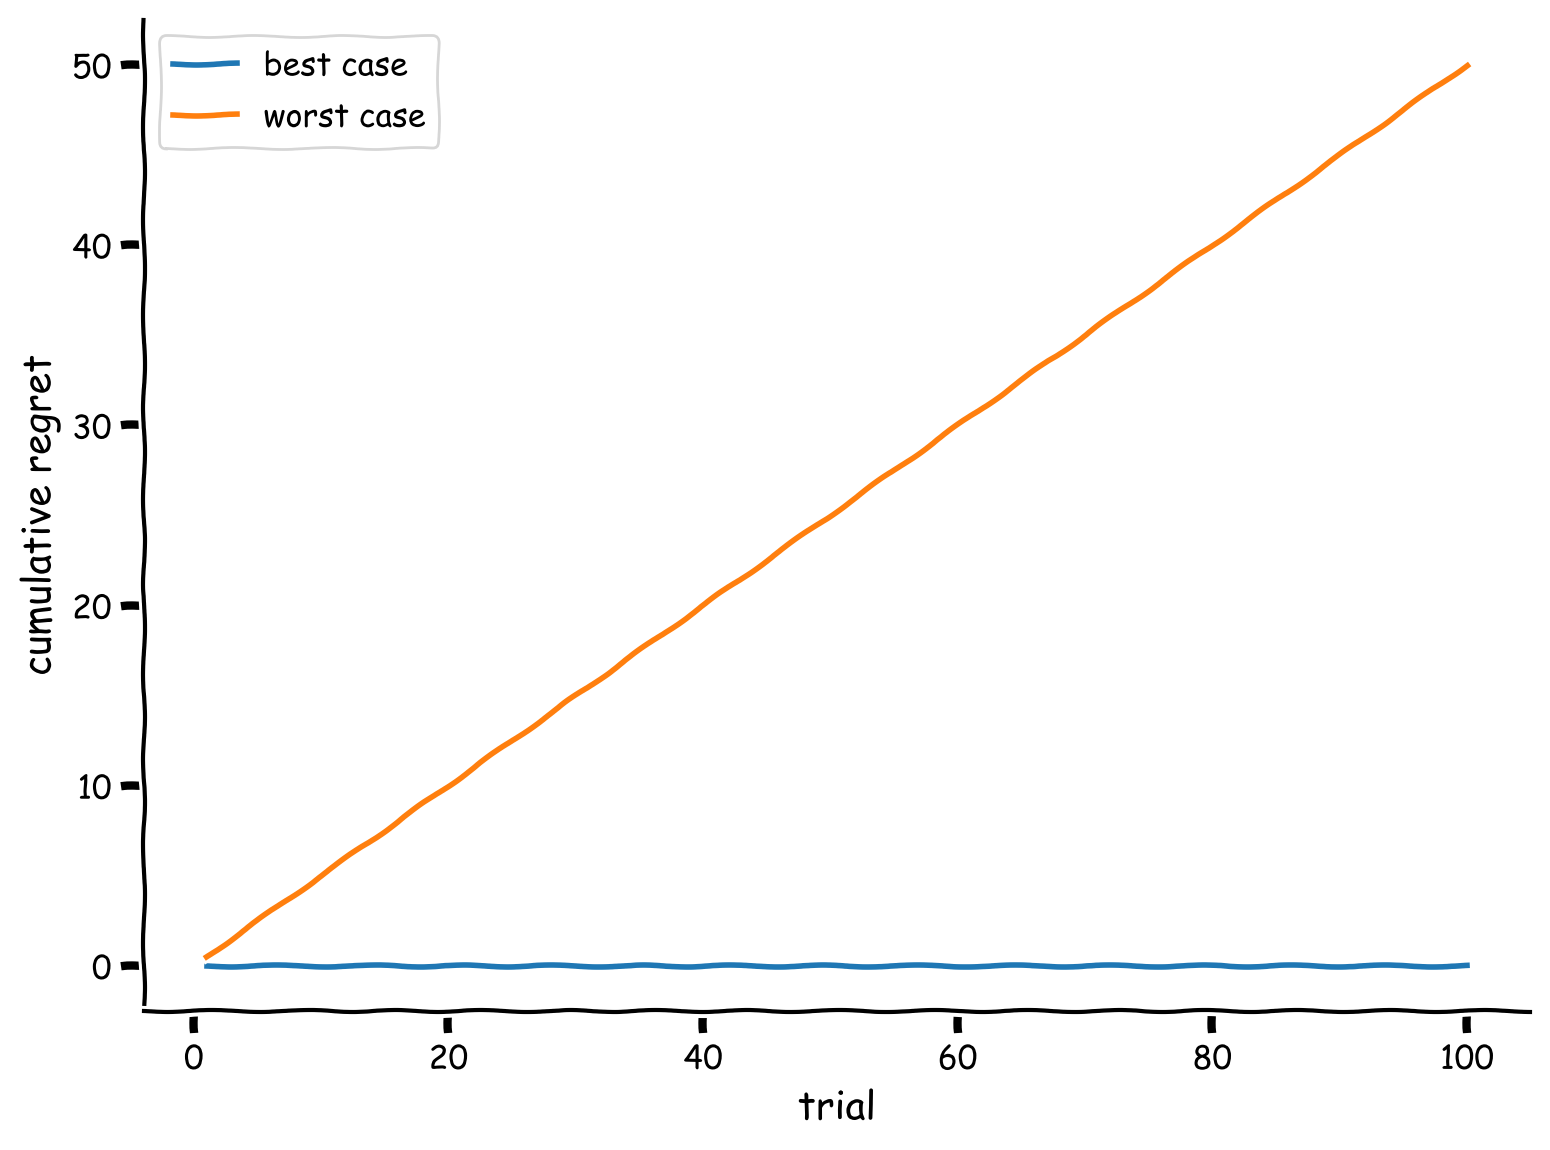

In [8]:
# to_remove solution
t = np.arange(1,101) # Array representing trials from 1 to 100
p_L = 0.25
p_R = 0.75

# In the best case scenario, the agent chooses the best arm every trial,
# leading to a cumulative regret of 0.
cr_best = np.zeros(100)

# In the worst-case scenario, the agent chooses the worst arm every trial,
# leading to per trial regret of the best arm's reward - the worst arm's reward
per_trial_regret = p_R - p_L
regret_worst = per_trial_regret * np.ones(100)
cr_worst = np.cumsum(regret_worst)

with plt.xkcd():
    plt.plot(t, cr_best, label = 'best case')
    plt.plot(t, cr_worst, label = 'worst case')

    plt.xlabel('trial')
    plt.ylabel('cumulative regret')
    plt.legend()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_2")

## Demo 1: Binary bandit

In this demo, we will simulate the binary bandit task to verify our intuitions. We'll 
use the Bayesian UCB (upper confidence bound) algorithm to solve the task. It keeps track of the posterior distribution of the reward of each arm and chooses the arm with the highest upper confidence bound. Thus, it will naturally balance exploration and exploitation: it will explore if the uncertainty is high and exploit if the uncertainty is low.

The Bayesian UCB algorithm works as follows:

1. Model the reward distribution of each arm as a Beta distribution. We start with a uniform prior for each arm, a Beta distribution with parameters $\alpha=1$ and $\beta=1$.
2. Pick the arm with the highest upper confidence bound, for example, the arm with the highest 95% confidence interval. 
3. Observe the reward.
4. Update the posterior distribution of the reward of the chosen arm.
5. Repeat steps 2-4 for a number of trials.

The posterior of the reward at time $t$ for arm $i$ is given by:

$$\text{Beta}(\alpha = 1 + \#\text{non rewarded trials}, \: \beta = 1 + \#\text{rewarded trials})$$

In [9]:
class BinaryBandit:
    """
    A class to represent a binary bandit.
    """
    def __init__(self, p):
        self.p = p
        self.t = 0

    def pull(self):
        reward = 1 if np.random.random() < self.p else 0
        return reward

    def step(self):
        self.t += 1
        pass

    def expected_reward(self):
        return self.p


def bayesian_ucb(bandits, num_trials, c=0.95):
    """
    Perform Bayesian UCB on a set of binary bandits

    Parameters:
    bandits (list): A list of binary bandits
    num_trials (int): The number of trials to run
    c (float): The confidence level for the UCB
    """
    num_bandits = len(bandits)
    rewards = np.zeros(num_trials)
    beliefs = np.ones((num_trials, num_bandits))
    ucb = np.ones((num_trials, num_bandits))
    lcb = np.ones((num_trials, num_bandits))
    selected_arms = np.zeros(num_trials)
    regrets = np.zeros(num_trials)
    expected_rewards = np.zeros((num_trials, num_bandits))

    per_arm_rewards = np.zeros(num_bandits)
    num_pulls = np.zeros(num_bandits)

    for t in range(num_trials):
        for bandit in bandits:
            bandit.step()
        successes = per_arm_rewards + 1
        failures = num_pulls - per_arm_rewards + 1

        ucb_values = scipy.stats.beta.ppf(c, successes, failures)
        lcb_values = scipy.stats.beta.ppf(1 - c, successes, failures)

        selected_arm = np.argmax(ucb_values)
        reward = bandits[selected_arm].pull()
        rewards[t] = reward
        per_arm_rewards[selected_arm] += reward
        num_pulls[selected_arm] += 1
        regret = np.max([bandit.expected_reward() for bandit in bandits]) - bandits[selected_arm].expected_reward()

        beliefs[t] = successes / (successes + failures)
        ucb[t] = ucb_values
        lcb[t] = lcb_values
        regrets[t] = regret

        selected_arms[t] = selected_arm
        expected_rewards[t] = np.array([bandit.expected_reward() for bandit in bandits])

    return rewards, expected_rewards, selected_arms, beliefs, lcb, ucb, np.cumsum(regrets)

def simulate(p_L, p_R, num_trials=100):
    bandits = [BinaryBandit(p_L), BinaryBandit(p_R)]
    rewards, expected_rewards, selected_arms, beliefs, lb, ub, cum_regret = bayesian_ucb(bandits, num_trials)
    cumulative_reward = np.cumsum(rewards)

    plot_ucb(beliefs, lb, ub, selected_arms, cumulative_reward, cum_regret, expected_rewards)

p_L_slider = FloatSlider(min=0, max=1, step=0.01, value=0.4, description='Left Arm Reward Probability')
p_R_slider = FloatSlider(min=0, max=1, step=0.01, value=0.6, description='Right Arm Reward Probability')
simulate_button = Button(description='Simulate!')
output = Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        simulate(p_L_slider.value, p_R_slider.value)

simulate_button.on_click(on_button_clicked)

display(p_L_slider, p_R_slider, simulate_button, output)

FloatSlider(value=0.4, description='Left Arm Reward Probability', max=1.0, step=0.01)

FloatSlider(value=0.6, description='Right Arm Reward Probability', max=1.0, step=0.01)

Button(description='Simulate!', style=ButtonStyle())

Output()

Try the demo with two very different probabilities ($p_L=0.05$ and $p_R=0.95$) and two similar probabilities ($p_L=0.51$ and $p_R=0.49$). Does this confirm the intuition you had in the previous discussion point?

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Demo")

## A fixed agent in a changing world

In the previous demo, we saw that the Bayesian UCB algorithm can solve the binary bandit task, exhibiting relatively low regret. However, the agent is fixed. In a more complex environment, the agent may need to adapt to changes. For example, the probabilities of the rewards of the arms might change over time. 

Let's see what happens with the Bayesian UCB algorithm when the probabilities of the rewards of the arms change over time. We will simulate a scenario where the probabilities of the rewards of the arms change after 50 trials. Whereas for the first 50 trials, the right arm will be most rewarded, we'll switch that from trial 51-100 onwards, then back again on trial 101-150, and so on.

In [10]:
class SwitchedBinaryBandit:
    """
    A class to represent a binary bandit that switches probabilities every dt timesteps.
    """
    def __init__(self, p, dt=50):
        self.p = p
        self.t = 0
        self.dt = dt

    def pull(self):
        reward = 1 if np.random.random() < self.p else 0
        return reward

    def step(self):
        self.t += 1
        if self.t % self.dt == 0:
            self.p = 1 - self.p
        pass

    def expected_reward(self):
        return self.p

def simulate(p_L, p_R, num_trials=100):

    bandits = [SwitchedBinaryBandit(p_L), SwitchedBinaryBandit(p_R)]
    rewards, expected_rewards, selected_arms, beliefs, lb, ub, cum_regret = bayesian_ucb(bandits, num_trials)
    cumulative_reward = np.cumsum(rewards)

    plot_ucb(beliefs, lb, ub, selected_arms, cumulative_reward, cum_regret, expected_rewards)

p_L_slider = FloatSlider(min=0, max=1, step=0.01, value=0.2, description='Left Arm Reward Probability')
p_R_slider = FloatSlider(min=0, max=1, step=0.01, value=0.8, description='Right Arm Reward Probability')
simulate_button = Button(description='Simulate!')
output = Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        simulate(p_L_slider.value, p_R_slider.value, 250)

simulate_button.on_click(on_button_clicked)

display(p_L_slider, p_R_slider, simulate_button, output)

FloatSlider(value=0.2, description='Left Arm Reward Probability', max=1.0, step=0.01)

FloatSlider(value=0.8, description='Right Arm Reward Probability', max=1.0, step=0.01)

Button(description='Simulate!', style=ButtonStyle())

Output()

## Discussion point 3

Our agent seemed to be doing well in the fixed scenario. However, in the second scenario, where the reward probabilities switch every 50 trials, the agent seems to be struggling, and the regret grows high. Why do you think this is the case?

In [ ]:
# to_remove explanation
"""
The agent models the reward probabilities of the two arms using fixed distributions.
There is no mechanism by which the agent can detect that there's a change in the
environment and rapidly update its beliefs. Its underlying model is not flexible,
and it cannot adapt to changes in the environment, leading to suboptimal performance.
"""

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_3")

---
# Section 2: Meta-learning and meta-reinforcement learning

In [11]:
# @title Video 2: Meta-RL

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'chc457oVgbo'), ('Bilibili', 'BV1o1421r7A6')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_meta_RL")

We introduced in the previous section the bandit task, the concept of regret, and an agent with a fixed policy that performs well in a fixed environment. We also saw the agent struggle when the environment changes. Humans and machines alike must display adaptive behaviour even as the environment changes. This is the essence of meta-learning.

Meta-learning is a sub-field of machine learning that corresponds to a process in which an algorithm "learns to learn". The idea is that the algorithm will learn during training how to adapt itself to different tasks. When faced with a new task, or changes in the environment, the trained algorithm will quickly adapt to this new task without requiring additional training (the weights of the algorithm are not changed).

In meta-reinforcement learning (meta-RL), this concept is applied to a reinforcement learning agent. During training, the agent is exposed to different episodes with different environments and gains meta-learning strategies. At deployment, the agent is faced with a new environment and uses the trials from that episode (the combination of actions, states and rewards) to learn a policy on the fly. Meta-RL algorithms are typically implemented using a deep learning architecture such as an LSTM. Once they are trained, the weights of the LSTM are fixed. When faced with a new episode, the activations in the LSTM implement nested learning in which the algorithm identifies the best arm for this specific episode.

## Prefrontal cortex as a meta-reinforcement learning system

Our discussion will follow this classic NeuroAI paper:

[1] Wang, Jane X., Zeb Kurth-Nelson, Dharshan Kumaran, Dhruva Tirumala, Hubert Soyer, Joel Z. Leibo, Demis Hassabis, and Matthew Botvinick. **"Prefrontal cortex as a meta-reinforcement learning system."** Nature neuroscience 21, no. 6 (2018): 860-868.

Available at [this link](https://www.nature.com/articles/s41593-018-0147-8).

This paper aims to reconcile two seemingly disparate ideas about learning in the prefrontal cortex (PFC). The activations in the PFC are correlated to actions, values and rewards, indicating that the PFC is engaged in RL. Another set of findings, including the fact that PFC activity is correlated with the recent history of rewards and actions, also suggests that the PFC is acting as a meta-RL agent. The paper proposes a meta-RL model, the weights of which are optimized during training to allow it to learn a second RL algorithm dynamically, as the properties of the environment change. They demonstrate a close match between findings in the neuroscience literature on the PFC and their trained RNN.

### Learning at different time scales

We will explore here the demo in Figure 1 of the paper. Figure C below shows the architecture of the meta-RL model, which is implemented as an LSTM. We will explore how, after training, the weights of the LSTM implement an RL procedure (e.g., we will see if this procedure deals with the exploration-exploitation tradeoff).

We will also explore how learning can occur at different time scales (see figure B below):

**Latent world state (fast)**: In this demo, at the start of each episode, a new set of probabilities $p_L$ and $p_R = 1-p_L$ are sampled. This corresponds to latent world state parameters that change on a slower time scale than the observations level (i.e., trials), but still at a relatively fast scale (each episode here has 100 trials).

**Context (slow)**: We think of the context level as a slower time scale at which the world is changing and affecting how the parameters of the latent world state are sampled. In this paper, the authors train their meta-RL model in two contexts. In the first (independent bandit context), the parameters of the successive latent world state (i.e., $p_L$ and $p_R$ from two successive episodes) are not correlated. There is no specific knowledge about the parameters that can be generalized from one episode to the next. In the second (correlated bandit context), the parameters are anti-correlated, similar to the scenario we explored in the last section with the UCB algorithm. Long-time scale integration can be leveraged for faster learning in the next episode. We will explore how training in these two different contexts affects performance.

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/static/learning_temporal_scales.png?raw=true" width=600 />

*Figure B - Learning across temporal scales*

### Architecture

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/static/model_architecture.png?raw=true" width=600 />

*Figure C - Model architecture. Adapted from Figure 1 of Wang et al. The PFC, along with the basal ganglia and directly connected thalamus, are modelled as a recurrent network. The synaptic weights are adjusted during training. a = action, r = reward, v = state value. Specifically, the algorithm is implemented as an LSTM (part b above shows the model in more detail, along with an inset of one LSTM model unit illustrating the maintenance mechanism).*


### Uncorrelated vs. correlated settings, seen through cumulative regret

In the paper, the average cumulative regret (defined above) of the meta-RL agent under the independent bandit and the correlated bandits contexts is computed over 300 episodes for the setting $p_L =0.25$ and $p_R = 0.75$ (see figure E). It is compared to the cumulative regret for three common algorithms (Gittin indices, Thompson sampling and UCB, also discussed above).


<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/static/cummulative_regret.png?raw=true" width=400 />

*Figure E - Cumulative Regret tested on a probability setting of 0.25, 0.75. Adapted from Figure 1 of Wang et al.*

Notice that the meta-RL agent trained in the correlated bandit context can capitalize on the information present in successive episodes and obtain a better performance than the one trained in the independent bandit context, matching the performance of the optimal algorithm (Gittins indices). The model also performs better than heuristics like Thompson sampling and UCB.

### The learned model dynamics implement an RL algorithm

The authors go on to demonstrate that across many contexts, the meta-RL algorithm can recapitulate classic findings from the neuroscience literature on the prefrontal cortex (PFC). Modelling the brain with ANNs allows us to do things which would otherwise be arduous in neuroscience, like peering inside the internals of the model. 

Here, we explore more in-depth how the activations in the LSTM implement the RL algorithm, by visualizing the top principal components (PCs) projections of the internal states of the LSTM during the different trials of an episode. Specifically, we look at the meta-RL agent trained in the correlated bandit setting (Figure F).

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/static/evolution.png?raw=true" width=600 />

*Figure F - Evolution of model activations during different episodes. Adapted from Figure 1 of Wang et al. Each subfigure is a different episode, with the arm probabilities shown at the top. The activations at the 100 trials of an episode are projected to their top two PCs and plotted using an asterisk when the model chooses the left arm and a triangle when the model chooses the right arm. The color indicates the trial number.  Adapted from Figure 1 of Wang et al.*

### Discussion point 4
In Figure F, the PCs of the model activations are obtained and the 100 trials in four episodes with specific probabilities are shown, projected onto PC1 and PC2. Observe the different patterns:
- Which two episodes show a fast convergence to an optimal action? How does this manifest?
- In the other two episodes, describe the trajectory of the activations, does the model change its estimation of the optimal arm? What leads to this change?
- What does the PC1 dimension appear to represent?


In [ ]:
# to_remove explanation
"""
The adaptation to fast-changing latent variables, as described in the changes in activation patterns over trials,
shows the algorithm's capability to adjust its internal representations based on feedback from the environment.

- The first and last plots show very fast convergence towards the optimal arm when the reward probabilities are
very different. The trajectory moves rapidly towards one or the other side of the PC space.

- In the middle two plots, correspond to more difficult settings, the model takes longer to converge,
The model starts by exploiting the left arm, but after sampling a right action, ends up converging on the right.

- The first PC appears to correspond to the certainty of the algorithm about the optimal arm
(low PC value = left arm, high PC value = right arm).
"""

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_4")

---
# Summary

In this tutorial, we examined how reinforcement learning can be adapted and scaled across different temporal dimensions, particularly focusing on meta-reinforcement learning (meta-RL) frameworks. We explored the concept of "learning to learn," where an algorithm adjusts its strategy based on accumulated knowledge from varied episodes, rather than from static training. This approach is important when dealing with dynamic environments or when the agent is introduced to novel scenarios not covered during initial training.

We focused on the binary bandit setup, where an agent decides between two options, balancing exploration (gathering information) and exploitation (leveraging known information for rewards). We showed the mechanics of one classic bandit strategy, the Upper Confidence Bound (UCB) algorithm. We showed it could solve a static bandit task, but struggled when the environment changed.

This motivated our discussion of meta-RL, where the agent is trained across episodes with varying conditions, thereby learning a flexible policy that can quickly adapt to new environments. The tutorial wrapped up by linking these learning processes to neural mechanisms, offering a bridge between artificial intelligence and neuroscientific understandings of learning.